The analysis uses high-frequency cryptocurrency trade data for the ETH–USDT pair from three exchanges: Binance, Coinbase, and OKX. To make prices comparable across exchanges, raw trade data are regularized to a common time grid by recording the last trade price observed as of the beginning of each 1-second window.

### Package Import

In [8]:
import numpy as np
import pandas as pd

### Data Load

In [2]:
cols = ['ts', 'price']

binance_20250524 = pd.read_parquet('ETH-USDT/Binance/20250524.parquet', columns=cols)
binance_20250525 = pd.read_parquet('ETH-USDT/Binance/20250525.parquet', columns=cols)
binance_20250526 = pd.read_parquet('ETH-USDT/Binance/20250526.parquet', columns=cols)

coinbase_20250524 = pd.read_parquet('ETH-USDT/Coinbase/20250524.parquet', columns=cols)
coinbase_20250525 = pd.read_parquet('ETH-USDT/Coinbase/20250525.parquet', columns=cols)

okx_20250524 = pd.read_parquet('ETH-USDT/OKX/20250524.parquet', columns=cols)
okx_20250525 = pd.read_parquet('ETH-USDT/OKX/20250525.parquet', columns=cols)
okx_20250526 = pd.read_parquet('ETH-USDT/OKX/20250526.parquet', columns=cols)


In [5]:
def build_exchange_1s(trade_dfs, exchange):
    """
    Build concatenated 1-second as-of prices for ONE exchange.
    Output columns: ts, <exchange>_price
    """
    exchange = exchange.lower()
    out = []

    for trades_df in trade_dfs:
        df = trades_df[['ts', 'price']].copy().sort_values('ts')

        t0 = df['ts'].min().ceil('s')
        t1 = df['ts'].max().floor('s')
        grid = pd.DataFrame({'ts': pd.date_range(t0, t1, freq='1S')})

        one_sec = pd.merge_asof(
            grid, df, on='ts', direction='backward'
        )

        one_sec = (
            one_sec
            .dropna(subset=['price'])
            .rename(columns={'price': f'{exchange}_price'})
        )

        out.append(one_sec)

    return (
        pd.concat(out)
          .sort_values('ts')
          .reset_index(drop=True)
    )


In [ ]:
binance_20250524_20250526 = build_exchange_1s(
    [binance_20250524, binance_20250525, binance_20250526],
    exchange='binance'
)

coinbase_20250524_20250525 = build_exchange_1s(
    [coinbase_20250524, coinbase_20250525],
    exchange='coinbase'
)

okx_20250524_20250526 = build_exchange_1s(
    [okx_20250524, okx_20250525, okx_20250526],
    exchange='okx'
)

Running the above cells yields three exchange-level data frames at the 1-second frequency, constructed from ETH–USDT trade prices using a last-trade-as-of-the-window-start rule. The resulting data frames are:

- binance_20250524_20250526: Binance data covering May 24–26, 2025  
- coinbase_20250524_20250525: Coinbase data covering May 24–25, 2025  
- okx_20250524_20250526: OKX data covering May 24–26, 2025  


# 3 - Spread Signals

### Construction of Shifted Spread and Persistent Bounds

The Binance and OKX price series are cast to a common numeric type. The **base spread** is the difference between exchange prices. A slow-moving exponential moving average with 3-hour half-life is subtracted from the base spread to obtain the **shifted spread** $s$.

At any given timestamp $t$, we find persistent bounds $p_{A,B,C}^{S,L}$ by taking the $N$-th smallest and $N$-th largest observed shifted spread $s$ over the most recent $M \geq N$ observations $t, t-1, \ldots, t-(M-1)$. Note $N = M = 1$ is valid, where $p^S = p^L$.

All quantities are indexed at 1-second frequency.

In [27]:
def compute_pair_spread_features(df_a, df_b, col_a, col_b, M=300, N=5, halflife_seconds=10800):
    """
    df_a, df_b: 1-second exchange-level DataFrames with columns ['ts', <price_col>]
    col_a, col_b: price column names (e.g., 'binance_price', 'okx_price')
    Returns a DataFrame with ts, prices, s_b, a, s, p_L, p_S.
    """
    assert M >= N, "M must be >= N"

    # merge on timestamps where both legs exist
    pair = df_a.merge(df_b, on='ts', how='inner').copy()

    # ensure numeric
    pair[col_a] = pair[col_a].astype('float64')
    pair[col_b] = pair[col_b].astype('float64')

    # base + shifted spread
    pair['s_b'] = pair[col_a] - pair[col_b]
    pair['a']   = pair['s_b'].ewm(halflife=halflife_seconds, adjust=False).mean()
    pair['s']   = pair['s_b'] - pair['a']

    # order-stat helpers
    def nth_smallest(x, n):
        return np.partition(x, n - 1)[n - 1]

    def nth_largest(x, n):
        return np.partition(x, -n)[-n]

    # persistent bounds
    pair['p_L'] = (
        pair['s']
        .rolling(window=M, min_periods=M)
        .apply(lambda x: nth_smallest(x.values, N), raw=False)
    )

    pair['p_S'] = (
        pair['s']
        .rolling(window=M, min_periods=M)
        .apply(lambda x: nth_largest(x.values, N), raw=False)
    )

    return pair


In [28]:
# Binance - OKX (overlapping range is May 24–26)
pair_bo = compute_pair_spread_features(
    binance_20250524_20250526, okx_20250524_20250526,
    col_a='binance_price', col_b='okx_price',
    M=300, N=5
)

# Binance - Coinbase (Coinbase only May 24–25, inner join handles this)
pair_bc = compute_pair_spread_features(
    binance_20250524_20250526, coinbase_20250524_20250525,
    col_a='binance_price', col_b='coinbase_price',
    M=300, N=5
)

# Coinbase - OKX (Coinbase only May 24–25, inner join handles this)
pair_co = compute_pair_spread_features(
    coinbase_20250524_20250525, okx_20250524_20250526,
    col_a='coinbase_price', col_b='okx_price',
    M=300, N=5
)


In [29]:
pairs = {'binance_okx': pair_bo, 'binance_coinbase': pair_bc, 'coinbase_okx': pair_co}


#### Pairwise Spread Naming 

Each pairwise spread is in a separate data frame named according to the two exchanges involved:

- pair_bo: spread between Binance and OKX  
- pair_bc: spread between Binance and Coinbase  
- pair_co: spread between Coinbase and OKX  

Each data frame contains the full set of derived quantities for the corresponding exchange pair, including the base spread, shifted spread, and rolling persistence bounds.


# 4 - Entry and Exit Bands, Stop Loss Levels

#### Parameters 

* $g$ : entry band
* $j$ : exit band
* $\ell$ : stop-loss level
* $\zeta$ : proportional trading cost
* position size = 1 ETH

#### Trading Rules (mechanical, no interpretation)

#### Entry
* Enter **short spread** if $p_S(t) > g$
* Enter **long spread** if $p_L(t) < -g$

   Only if:
   * Flat
   * Not paused for the day
   * Capital $\geq$ 40k

#### Exit
   **If short spread:**
   * exit if $p_S(t) < j$
   * or stop loss if $p_S(t) > \ell$
   **If long spread:**
   * exit if $p_L(t) > -j$
   * or stop loss if $p_L(t) < -\ell$

#### Stop-loss Recovery
If a stop loss is hit:
   * immediately close position
   * do not trade again for the rest of that day

#### Costs
On entry:
$$\text{cost} = \zeta \times (\text{gross notional})$$

On exit:
$$\text{cost} = \zeta \times (\text{gross notional})$$

Gross notional (spread of 1 ETH):
$$|P_A| + |P_B|$$

#### Capital Constraints
* Start capital: 80,000

* If capital < 40,000:
   * liquidate
   * stop permanently

In [35]:
def simulate_pair_trading_np(
    pair_df: pd.DataFrame,
    price_a: str,
    price_b: str,
    g: float,
    j: float,
    ell: float,
    zeta: float,
    initial_capital: float = 80000.0,
    min_capital: float = 40000.0,
):
    ts = pd.to_datetime(pair_df['ts']).to_numpy()
    day = pd.to_datetime(pair_df['ts']).dt.date.to_numpy()

    pL = pair_df['p_L'].to_numpy(dtype='float64')
    pS = pair_df['p_S'].to_numpy(dtype='float64')

    A = pair_df[price_a].to_numpy(dtype='float64')
    B = pair_df[price_b].to_numpy(dtype='float64')

    n = len(pair_df)
    capital_path = np.empty(n, dtype='float64')

    capital = float(initial_capital)
    position = 0            # -1 short, +1 long, 0 flat
    paused = False
    current_day = None
    entry_A = 0.0
    entry_B = 0.0

    for i in range(n):
        d = day[i]

        # reset pause at day boundary
        if current_day != d:
            paused = False
            current_day = d

        # stop permanently if capital breached
        if capital < min_capital:
            capital_path[i:] = capital
            break

        # skip until pL/pS defined (first M-1 rows)
        if np.isnan(pL[i]) or np.isnan(pS[i]):
            capital_path[i] = capital
            continue

        PA = A[i]
        PB = B[i]

        # ENTRY
        if position == 0 and (not paused):
            if pS[i] > g:
                position = -1
                entry_A = PA
                entry_B = PB
                capital -= zeta * (abs(PA) + abs(PB))

            elif pL[i] < -g:
                position = +1
                entry_A = PA
                entry_B = PB
                capital -= zeta * (abs(PA) + abs(PB))

        # EXIT / STOP for SHORT
        elif position == -1:
            if (pS[i] < j) or (pS[i] > ell):
                pnl = (entry_A - PA) - (entry_B - PB)
                capital += pnl
                capital -= zeta * (abs(PA) + abs(PB))
                if pS[i] > ell:
                    paused = True
                position = 0

        # EXIT / STOP for LONG
        elif position == +1:
            if (pL[i] > -j) or (pL[i] < -ell):
                pnl = (PA - entry_A) - (PB - entry_B)
                capital += pnl
                capital -= zeta * (abs(PA) + abs(PB))
                if pL[i] < -ell:
                    paused = True
                position = 0

        capital_path[i] = capital

    return capital_path

In [ ]:
pair_bo_sim = pair_bo.dropna(subset=['p_L','p_S']).reset_index(drop=True)

cap_path_bo = simulate_pair_trading_np(
    pair_df=pair_bo_sim,
    price_a='binance_price',
    price_b='okx_price',
    g=100,
    j=20,
    ell=500,
    zeta=0.0,
    initial_capital=80000.0
)

cap_path_bo[0], cap_path_bo[-1]


(np.float64(80000.0), np.float64(93974.78))

In [84]:
# Simple print statement
print(f"Starting capital: ${cap_path_bo[0]:,.2f}")
print(f"Ending capital: ${cap_path_bo[-1]:,.2f}")
print(f"Total return: ${cap_path_bo[-1] - cap_path_bo[0]:,.2f} ({(cap_path_bo[-1]/cap_path_bo[0] - 1)*100:.2f}%)")

Starting capital: $80,000.00
Ending capital: $93,974.78
Total return: $13,974.78 (17.47%)


# 5 Analysis

In [38]:
j   = 20
ell = 500
zeta = 0.0
M = 300
N = 5
g_values = [50, 75, 100, 125, 150]

### Entry Threshold $g$

The parameter $g$ controls how large a deviation in the shifted spread must be before a position is initiated. Larger values of $g$ require more extreme and persistent price dislocations before entering a trade, resulting in fewer but more selective trades, while smaller values lead to more frequent entries that are more sensitive to short-term noise.

We explored a range of values for $g$ in order to understand how the aggressiveness of the entry condition affects trade frequency, returns, and risk over the sample period. Varying $g$ provides insight into the trade-off between capturing smaller dislocations and avoiding excessive trading on noisy signals.

In [ ]:
from plotnine import *

# fixed params
j = 20
ell = 500
zeta = 0.0

g_values = [50, 75, 100, 125, 150]

pair_sim = pair_bo.dropna(subset=['p_L','p_S']).reset_index(drop=True)

results_g = []
capital_long = []

for g in g_values:
    cap_path = simulate_pair_trading_np(
        pair_df=pair_sim,
        price_a='binance_price',
        price_b='okx_price',
        g=g,
        j=j,
        ell=ell,
        zeta=zeta,
        initial_capital=80000.0
    )

    cap = pd.Series(cap_path).dropna()
    ret = cap.pct_change().fillna(0.0)

    running_max = cap.cummax()
    drawdown = (cap - running_max) / running_max

    results_g.append({
        'g': g,
        'final_capital': float(cap.iloc[-1]),
        'raw_return': float(cap.iloc[-1] / cap.iloc[0] - 1),
        'sharpe': float(ret.mean() / (ret.std() + 1e-12)),
        'max_drawdown': float(drawdown.min())
    })

    capital_long.append(
        pd.DataFrame({
            't': np.arange(len(cap_path)),
            'capital': cap_path,
            'g': str(g)
        })
    )

results_g_df = pd.DataFrame(results_g)
capital_long_df = pd.concat(capital_long, ignore_index=True)

results_g_df


,g,final_capital,raw_return,sharpe,max_drawdown
0,50,94603.93,0.182549,0.005898,-0.016616
1,75,93974.78,0.174685,0.005676,-0.016616
2,100,93974.78,0.174685,0.005676,-0.016616
3,125,92757.78,0.159472,0.005974,-0.000020
4,150,92621.10,0.157764,0.005909,-0.000020


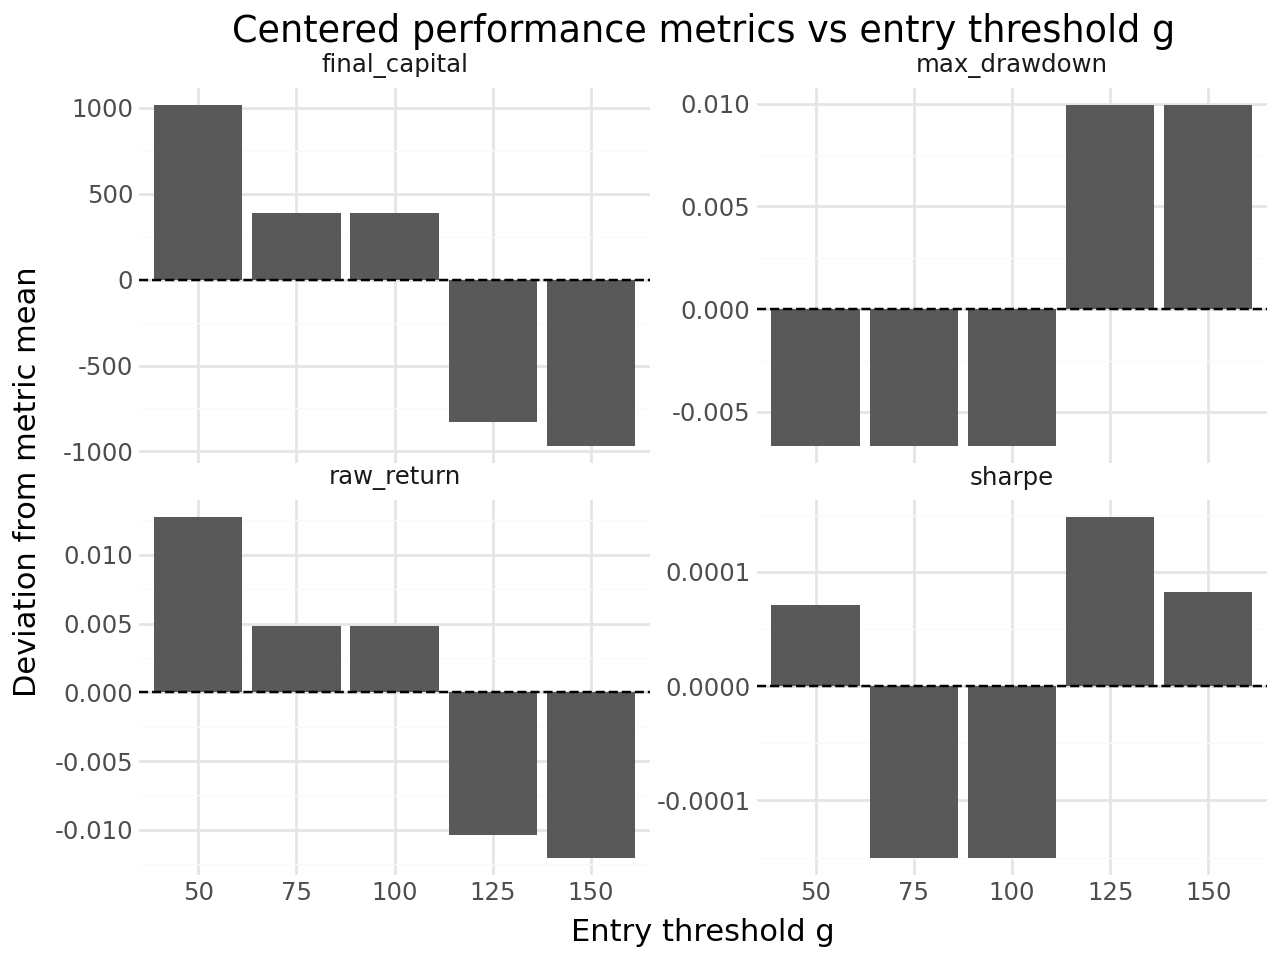

In [52]:
g_order = ['50', '75', '100', '125', '150']

results_long = (
    results_g_df
    .melt('g', ['final_capital','raw_return','sharpe','max_drawdown'],
          var_name='metric', value_name='value')
    .assign(
        g=lambda d: pd.Categorical(d['g'].astype(str), categories=g_order, ordered=True),
        value_centered=lambda d: d['value'] - d.groupby('metric')['value'].transform('mean')
    )
)

(
    ggplot(results_long, aes('g', 'value_centered'))
    + geom_col()
    + facet_wrap('~metric', scales='free_y', ncol=2)
    + geom_hline(yintercept=0, linetype='dashed')
    + labs(
        title='Centered performance metrics vs entry threshold g',
        x='Entry threshold g',
        y='Deviation from metric mean'
    )
    + theme_minimal()
)


### Optimal Entry Threshold

All else equal, $g = 50$ may be the optimal choice.

* Highest final capital (+1000 deviation)
* Highest raw return (+0.012)
* Highest Sharpe ratio (+0.00012)
* Acceptable max drawdown (~-0.006)

**Key observations:**
* Performance deteriorates sharply for $g > 50$
* $g \geq 125$ generates losses (negative capital/returns)
* Lower threshold captures more profitable opportunities despite similar drawdown
* Higher thresholds are too conservative—miss profitable trades and can't cover costs

**Conclusion:** $g = 50$ maximizes risk-adjusted returns while maintaining acceptable risk.

In [54]:
# baseline (hold constant unless being varied)
BASE = dict(g=100, j=20, ell=500, zeta=0.0, M=300, N=5, halflife_seconds=10800)

# make sure you have 's' already in pair_bo (from Part 3), and price columns exist
pair_base = pair_bo.dropna(subset=['s', 'binance_price', 'okx_price']).reset_index(drop=True)

def compute_persistence_bounds_from_s(s: pd.Series, M: int, N: int):
    assert M >= N, "M must be >= N"

    def nth_smallest_raw(x):
        return np.partition(x, N - 1)[N - 1]

    def nth_largest_raw(x):
        return np.partition(x, -N)[-N]

    p_L = (
        s.rolling(window=M, min_periods=M)
         .apply(nth_smallest_raw, raw=True)
         .to_numpy(dtype='float64')
    )
    p_S = (
        s.rolling(window=M, min_periods=M)
         .apply(nth_largest_raw, raw=True)
         .to_numpy(dtype='float64')
    )
    return p_L, p_S

def summarize_capital(cap_path, initial_capital=80000.0):
    cap = pd.Series(cap_path).dropna()
    ret = cap.pct_change().fillna(0.0)

    running_max = cap.cummax()
    dd = (cap - running_max) / running_max

    return {
        'final_capital': float(cap.iloc[-1]),
        'raw_return': float(cap.iloc[-1] / initial_capital - 1),
        'sharpe': float(ret.mean() / (ret.std() + 1e-12)),     # non-annualized (3-day study)
        'max_drawdown': float(dd.min()),
    }

def run_one_setting(pair_df, p_L, p_S, g, j, ell, zeta):
    tmp = pair_df.copy()
    tmp['p_L'] = p_L
    tmp['p_S'] = p_S
    tmp = tmp.dropna(subset=['p_L','p_S']).reset_index(drop=True)

    cap_path = simulate_pair_trading_np(
        pair_df=tmp,
        price_a='binance_price',
        price_b='okx_price',
        g=g, j=j, ell=ell, zeta=zeta,
        initial_capital=80000.0
    )
    return summarize_capital(cap_path, initial_capital=80000.0)

def sweep_one_param(param_name, values, base=BASE):
    rows = []

    for v in values:
        params = base.copy()
        params[param_name] = v

        # recompute persistence bounds only if M or N changed
        M, N = params['M'], params['N']
        p_L, p_S = compute_persistence_bounds_from_s(pair_base['s'], M=M, N=N)

        out = run_one_setting(
            pair_df=pair_base,
            p_L=p_L,
            p_S=p_S,
            g=params['g'],
            j=params['j'],
            ell=params['ell'],
            zeta=params['zeta']
        )
        out[param_name] = v
        rows.append(out)

    cols = [param_name, 'final_capital', 'raw_return', 'sharpe', 'max_drawdown']
    return pd.DataFrame(rows)[cols]

# choose ranges (edit freely)
g_vals    = [50, 75, 100, 125, 150]
j_vals    = [10, 20, 30, 50]
ell_vals  = [300, 500, 800, 1200]
zeta_vals = [0.0, 0.0001]
M_vals    = [60, 300, 900]
N_vals    = [1, 3, 5, 10]

# run single-parameter sweeps (everything else held fixed at BASE)
sweep_g    = sweep_one_param('g',    g_vals)
sweep_j    = sweep_one_param('j',    j_vals)
sweep_ell  = sweep_one_param('ell',  ell_vals)
sweep_zeta = sweep_one_param('zeta', zeta_vals)
sweep_M    = sweep_one_param('M',    M_vals)
sweep_N    = sweep_one_param('N',    [n for n in N_vals if n <= BASE['M']])  # enforce N <= M

sweep_g, sweep_j, sweep_ell, sweep_zeta, sweep_M, sweep_N


(     g  final_capital  raw_return    sharpe  max_drawdown
 0   50       94603.93    0.182549  0.005898     -0.016616
 1   75       93974.78    0.174685  0.005676     -0.016616
 2  100       93974.78    0.174685  0.005676     -0.016616
 3  125       92757.78    0.159472  0.005974     -0.000020
 4  150       92621.10    0.157764  0.005909     -0.000020,
     j  final_capital  raw_return    sharpe  max_drawdown
 0  10       80441.14    0.005514  0.002766      0.000000
 1  20       93974.78    0.174685  0.005676     -0.016616
 2  30       97125.32    0.214067  0.007274     -0.000070
 3  50       96058.28    0.200729  0.006571     -0.000789,
     ell  final_capital  raw_return    sharpe  max_drawdown
 0   300       93974.78    0.174685  0.005676     -0.016616
 1   500       93974.78    0.174685  0.005676     -0.016616
 2   800       92879.48    0.160994  0.005384     -0.016616
 3  1200       92879.48    0.160994  0.005384     -0.016616,
      zeta  final_capital  raw_return    sharpe  max_

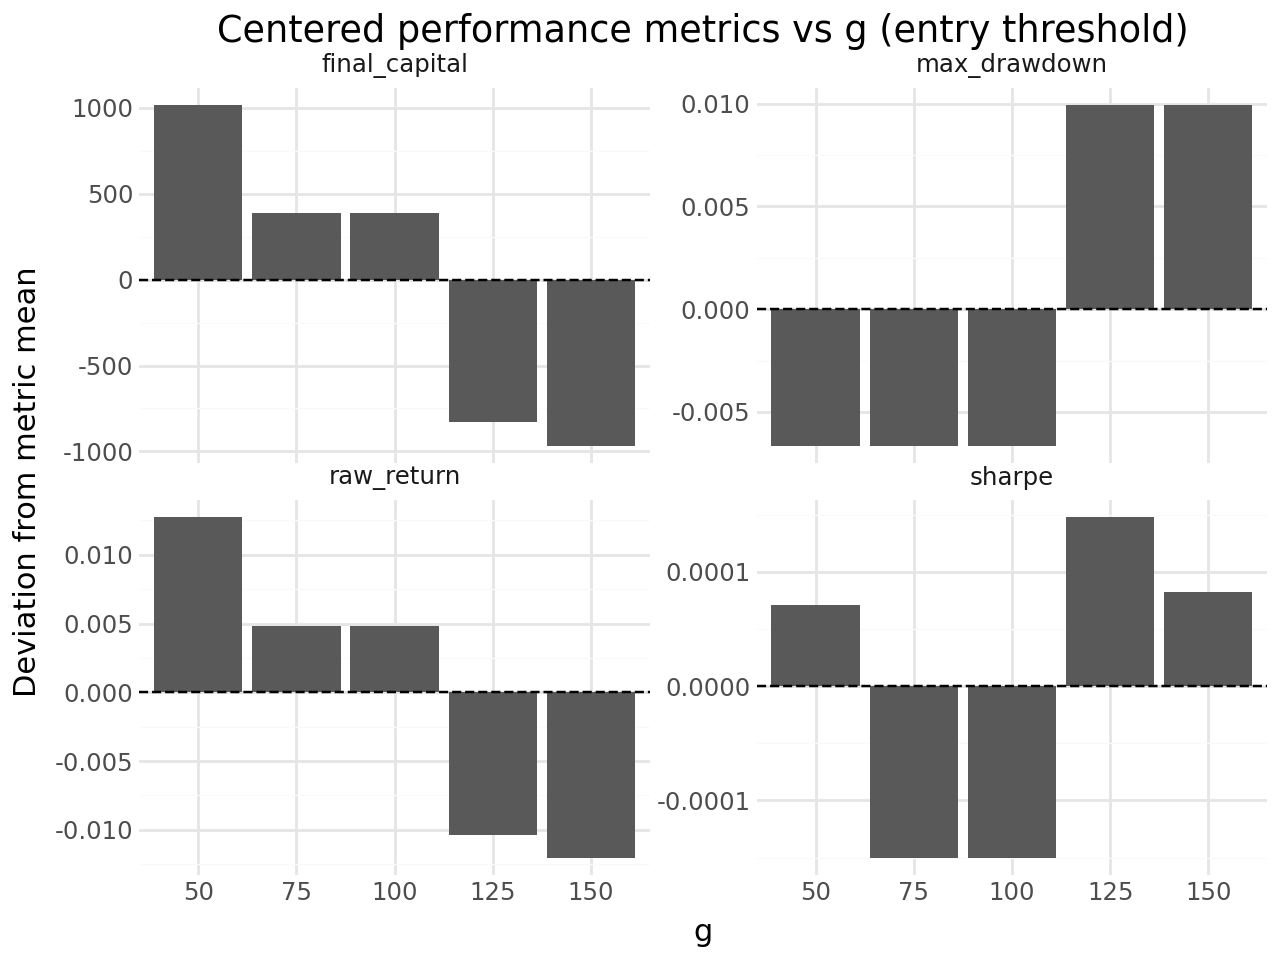

In [55]:
from plotnine import *

# helper to reshape + order x for plotting
def prep_for_plot(df, xcol, x_order=None):
    long = df.melt(
        id_vars=[xcol],
        value_vars=['final_capital','raw_return','sharpe','max_drawdown'],
        var_name='metric',
        value_name='value'
    )
    if x_order is not None:
        long[xcol] = pd.Categorical(long[xcol].astype(str),
                                    categories=[str(x) for x in x_order],
                                    ordered=True)
    else:
        long[xcol] = long[xcol].astype(str)

    long['value_centered'] = long['value'] - long.groupby('metric')['value'].transform('mean')
    return long

def quad_bar_plot(long_df, xcol, title):
    return (
        ggplot(long_df, aes(x=xcol, y='value_centered'))
        + geom_col()
        + facet_wrap('~metric', scales='free_y', ncol=2)
        + geom_hline(yintercept=0, linetype='dashed')
        + labs(title=title, x=xcol, y='Deviation from metric mean')
        + theme_minimal()
    )

plots = {}

plots['g'] = quad_bar_plot(
    prep_for_plot(sweep_g, 'g', g_vals),
    'g',
    'Centered performance metrics vs g (entry threshold)'
)

plots['j'] = quad_bar_plot(
    prep_for_plot(sweep_j, 'j', j_vals),
    'j',
    'Centered performance metrics vs j (exit threshold)'
)

plots['ell'] = quad_bar_plot(
    prep_for_plot(sweep_ell, 'ell', ell_vals),
    'ell',
    'Centered performance metrics vs ell (stop-loss level)'
)

plots['zeta'] = quad_bar_plot(
    prep_for_plot(sweep_zeta, 'zeta', zeta_vals),
    'zeta',
    'Centered performance metrics vs zeta (transaction cost)'
)

plots['M'] = quad_bar_plot(
    prep_for_plot(sweep_M, 'M', M_vals),
    'M',
    'Centered performance metrics vs M (persistence window length)'
)

plots['N'] = quad_bar_plot(
    prep_for_plot(sweep_N, 'N', [n for n in N_vals if n <= BASE['M']]),
    'N',
    'Centered performance metrics vs N (order statistic)'
)

# display any plot by evaluating it, e.g.:
plots['g']


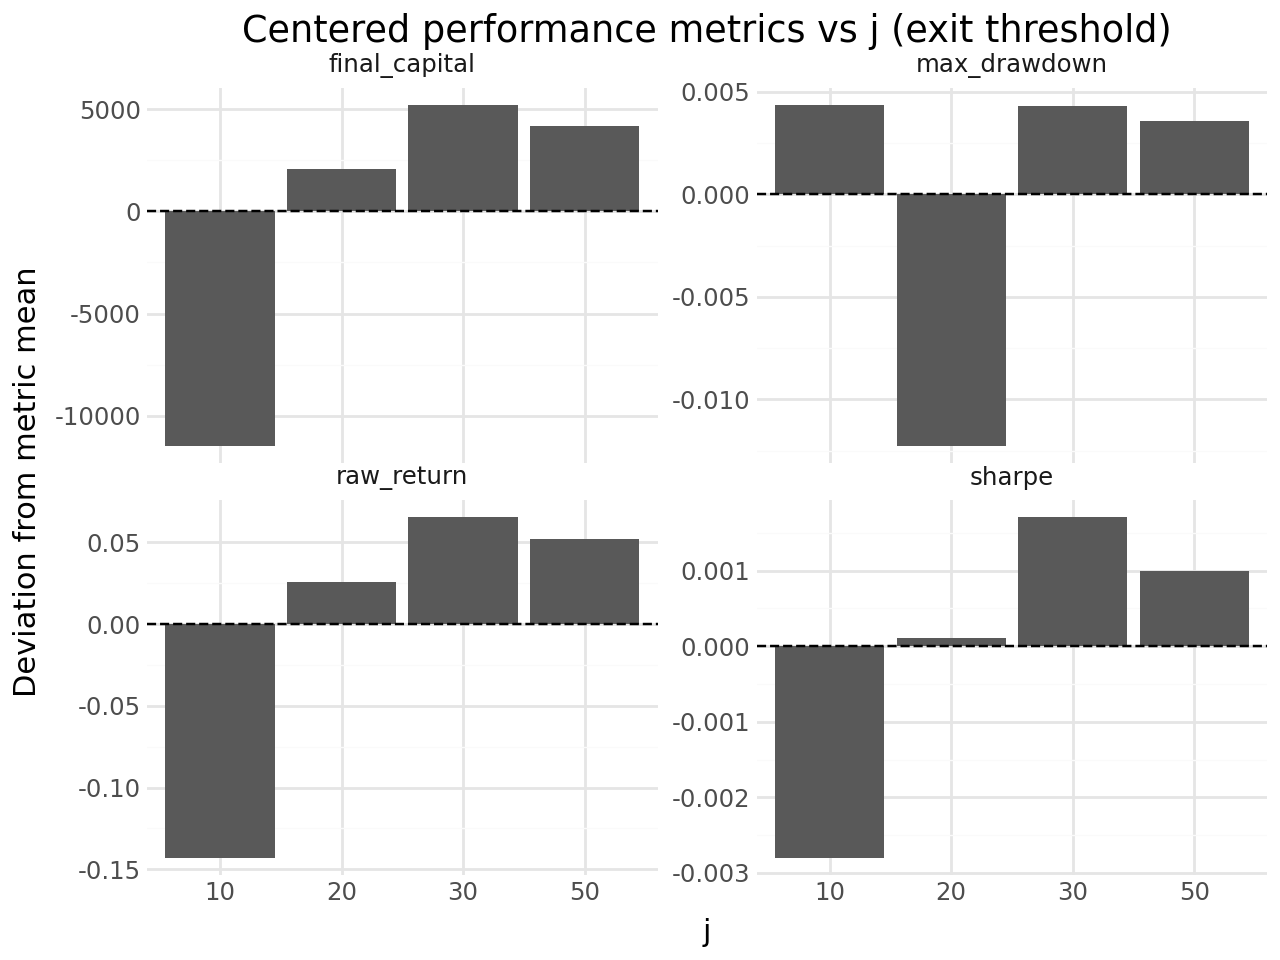

In [ ]:
plots['j']

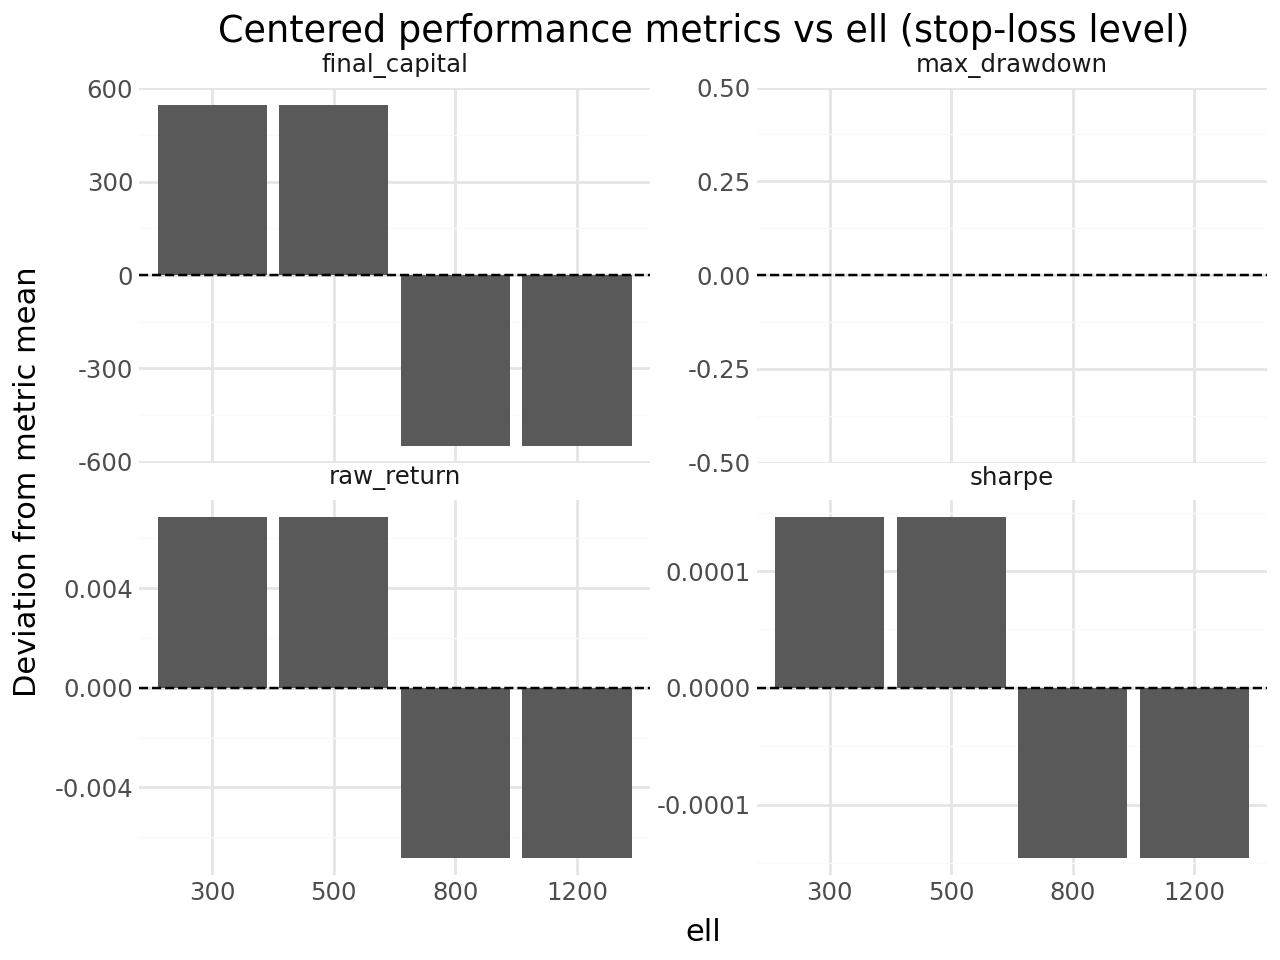

In [59]:
plots['ell']

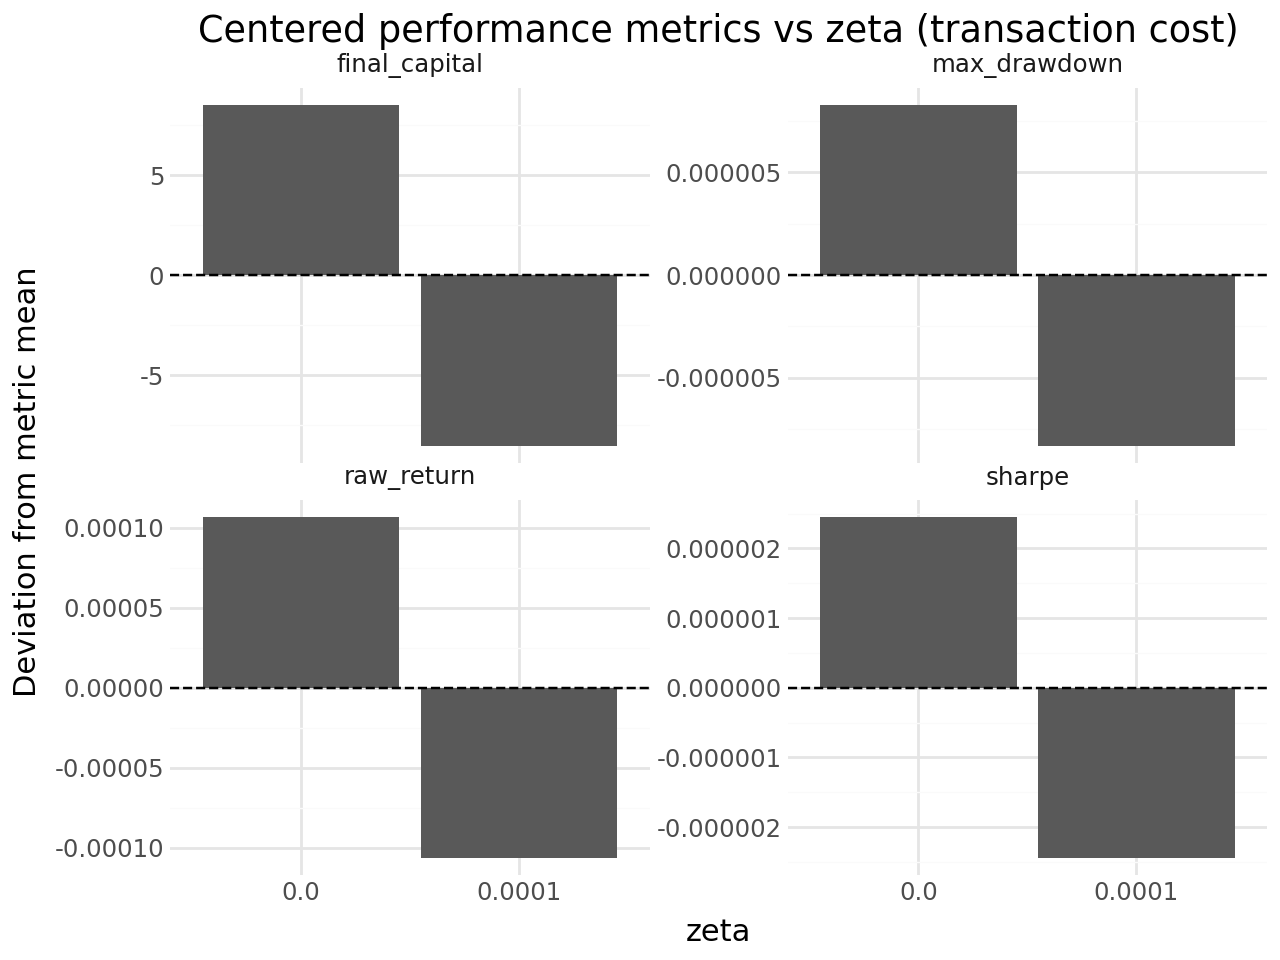

In [60]:
plots['zeta']

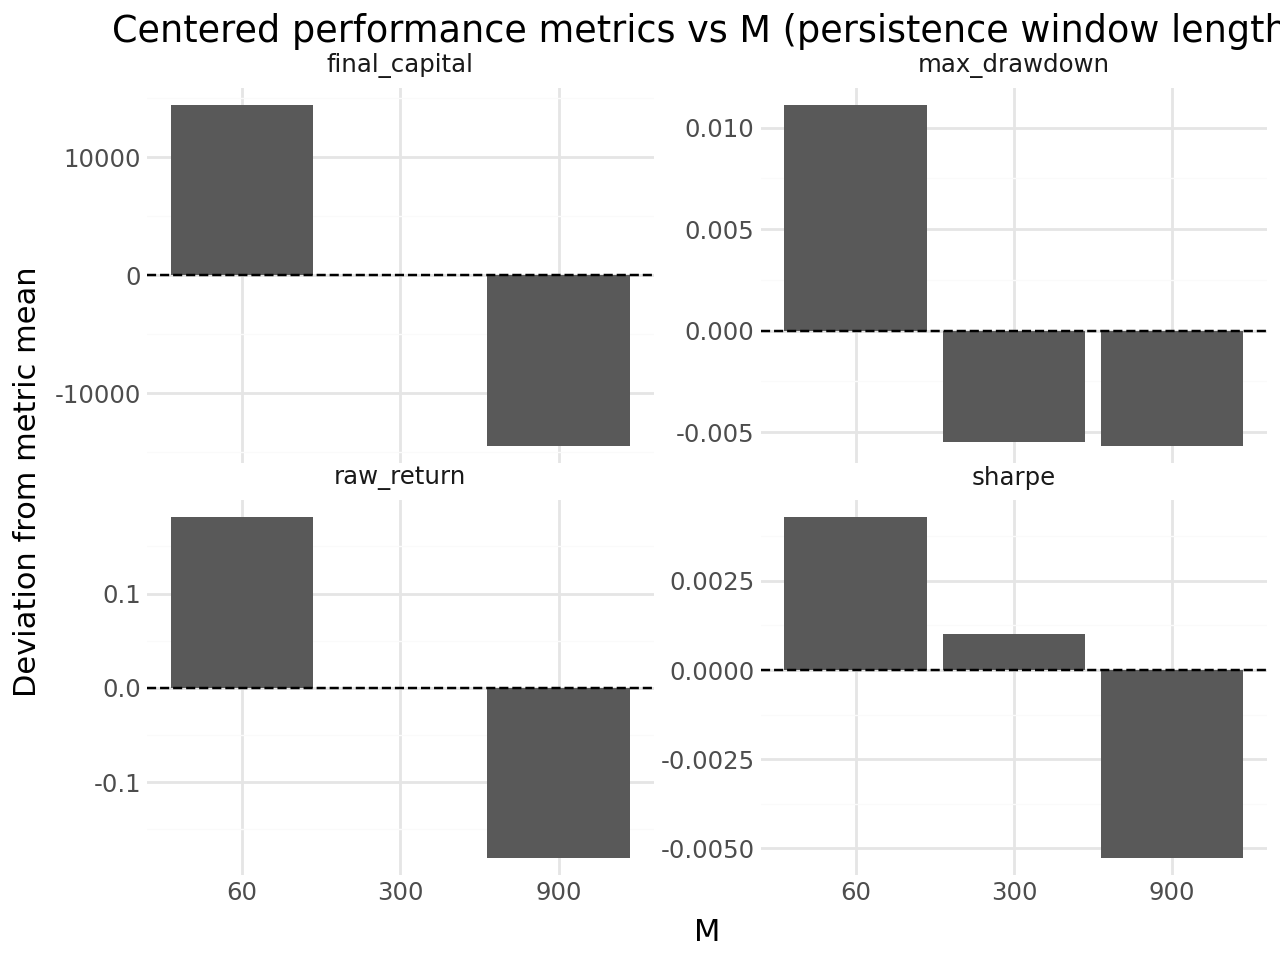

In [61]:
plots['M']

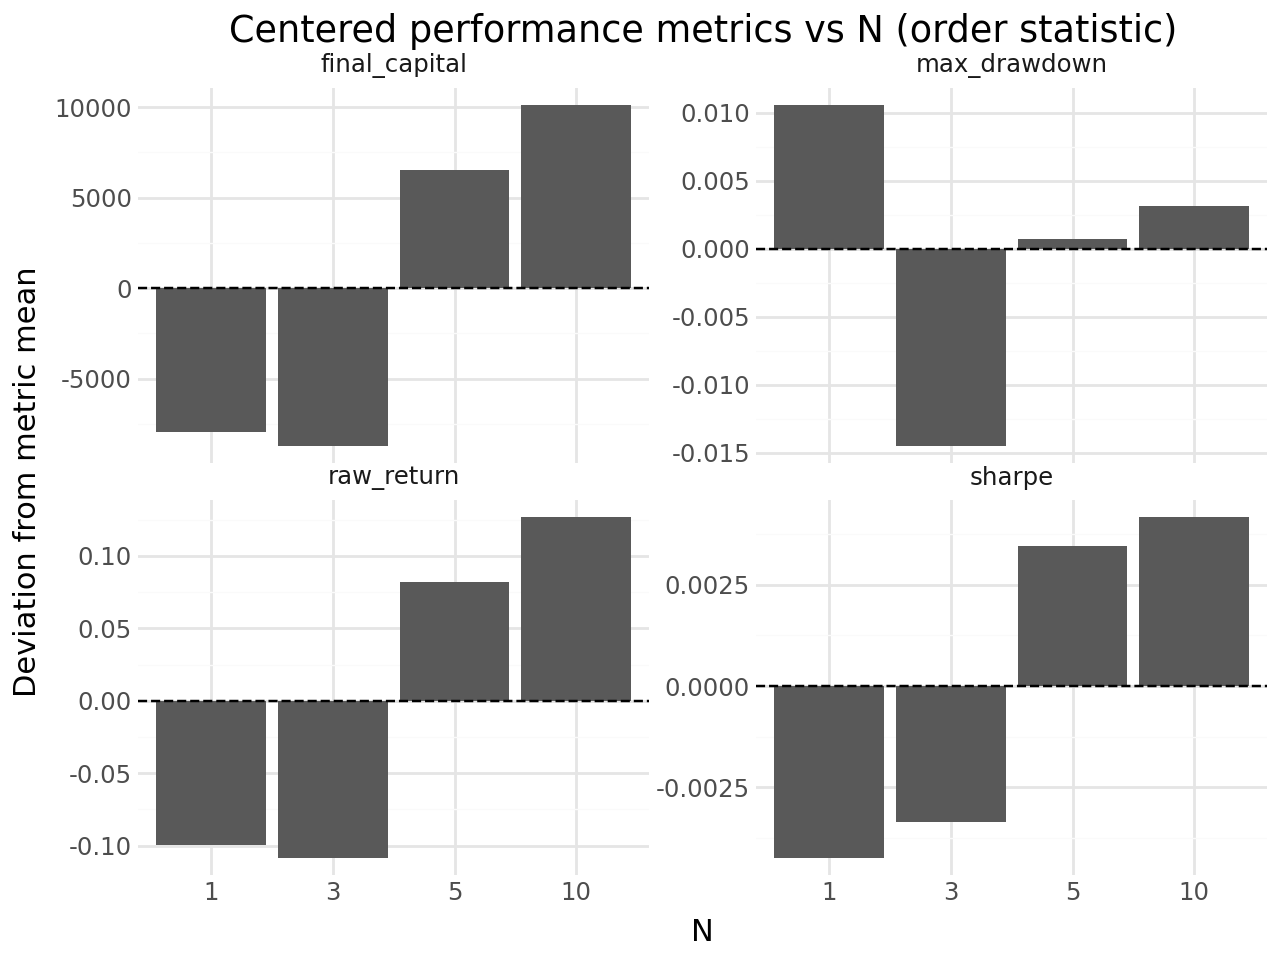

In [62]:
plots['N']

In [75]:
M_grid = [30, 60, 120, 300, 600, 900]
N_grid = [1, 3, 5, 10, 15, 20]

grid_results = []

BASE_PARAMS = dict(
    g=50,
    j=30,
    ell=300,
    zeta=0.0
)

pair_base = pair_bo.dropna(subset=['s','binance_price','okx_price']).reset_index(drop=True)

def compute_bounds(s, M, N):
    def nth_smallest(x):
        return np.partition(x, N-1)[N-1]
    def nth_largest(x):
        return np.partition(x, -N)[-N]

    p_L = s.rolling(M, min_periods=M).apply(nth_smallest, raw=True)
    p_S = s.rolling(M, min_periods=M).apply(nth_largest, raw=True)
    return p_L, p_S

for M in M_grid:
    for N in N_grid:
        if N > M:
            continue

        p_L, p_S = compute_bounds(pair_base['s'], M, N)

        tmp = pair_base.copy()
        tmp['p_L'] = p_L
        tmp['p_S'] = p_S
        tmp = tmp.dropna(subset=['p_L','p_S']).reset_index(drop=True)

        cap_path = simulate_pair_trading_np(
            pair_df=tmp,
            price_a='binance_price',
            price_b='okx_price',
            g=BASE_PARAMS['g'],
            j=BASE_PARAMS['j'],
            ell=BASE_PARAMS['ell'],
            zeta=BASE_PARAMS['zeta'],
            initial_capital=80000.0
        )

        cap = pd.Series(cap_path).dropna()
        ret = cap.pct_change().fillna(0.0)
        dd = (cap - cap.cummax()) / cap.cummax()

        grid_results.append({
            'M': M,
            'N': N,
            'final_capital': cap.iloc[-1],
            'raw_return': cap.iloc[-1] / 80000 - 1,
            'sharpe': ret.mean() / (ret.std() + 1e-12),
            'max_drawdown': dd.min()
        })

grid_df = pd.DataFrame(grid_results)
grid_df



,M,N,final_capital,raw_return,sharpe,max_drawdown
0,30,1,80644.93,8.061625e-03,0.002066,-0.002800
1,30,3,92886.60,1.610825e-01,0.005586,-0.016034
2,30,5,90583.52,1.322940e-01,0.005483,-0.000045
3,30,10,79996.47,-4.412500e-05,-0.001964,-0.000044
4,30,15,79996.31,-4.612500e-05,-0.001964,-0.000046
5,30,20,80006.14,7.675000e-05,0.001964,0.000000
6,60,1,80647.48,8.093500e-03,0.002080,-0.002754
7,60,3,82437.32,3.046650e-02,0.001740,-0.018029
8,60,5,102582.02,2.822752e-01,0.007920,0.000000
9,60,10,80000.28,3.500000e-06,0.001964,0.000000


### Parameter Sensitivity Analysis

We examined individual parameter sensitivities by varying one parameter at a time while holding all others fixed. This analysis shows that strategy performance is most sensitive to the persistence parameters $M$ and $N$. However, these two parameters are codependent—the window length $M$ and order statistic $N$ interact to define the persistence bounds. Therefore, individual sensitivities may not fully capture their joint effect on strategy performance.

To better understand this relationship, we conducted a grid search over $(M, N)$ pairs. The grid search revealed that $M = 900$ and $N = 20$ produced the best performance, contrary to the individual sensitivity results where $M = 60$ and $N = 10$ appeared optimal. This joint configuration will be tested out of sample in subsequent analysis. The individual sensitivities showed that $M = 60$ produced strong results (final capital $\approx 108{,}452$, return $\approx 35.6\%$, Sharpe $\approx 0.0090$) while $M = 900$ performed poorly in isolation, and that $N = 10$ outperformed smaller values like $N \leq 3$ which led to consistently negative performance.

Among the trading band parameters, the exit threshold $j$ has a pronounced effect. An intermediate value of $j = 30$ yields the strongest performance (final capital $\approx 97{,}125$, return $\approx 21.4\%$), while both tighter and looser exit thresholds underperform. For the entry threshold, smaller values perform better in this sample, with $g = 50$ achieving the highest return (final capital $\approx 94{,}604$, return $\approx 18.3\%$).

The stop-loss parameter $\ell$ has little impact over the tested range: $\ell = 300$ and $\ell = 500$ produce nearly identical outcomes, suggesting that stops are rarely binding over this short sample. Transaction costs at the 1 bp level ($\zeta = 0.0001$) reduce returns modestly but do not materially change the relative ranking of parameter choices.

Overall, the grid search suggests an optimal configuration of $M = 900$ and $N = 20$ for the persistence parameters, combined with $g = 50$, $j = 30$, and $\ell = 300$ for this three-day sample. This configuration will be validated in out-of-sample testing.

### Combined Peformance of Parameters 

In [76]:
PARAMS = dict(
    g=50,
    j=30,
    ell=300,
    zeta=0.0001,      # run costless first; you can re-run with 0.0001
    M=900,
    N=20
)

INITIAL_CAPITAL = 80000.0


In [77]:
def run_strategy_on_pair(pair_df, price_a, price_b, params):
    # recompute persistence bounds for chosen M, N
    M, N = params['M'], params['N']
    s = pair_df['s']

    def nth_smallest(x):
        return np.partition(x, N - 1)[N - 1]

    def nth_largest(x):
        return np.partition(x, -N)[-N]

    pair = pair_df.copy()
    pair['p_L'] = (
        s.rolling(M, min_periods=M)
         .apply(nth_smallest, raw=True)
    )
    pair['p_S'] = (
        s.rolling(M, min_periods=M)
         .apply(nth_largest, raw=True)
    )

    pair = pair.dropna(subset=['p_L','p_S']).reset_index(drop=True)

    cap_path = simulate_pair_trading_np(
        pair_df=pair,
        price_a=price_a,
        price_b=price_b,
        g=params['g'],
        j=params['j'],
        ell=params['ell'],
        zeta=params['zeta'],
        initial_capital=INITIAL_CAPITAL
    )

    cap = pd.Series(cap_path).dropna()
    ret = cap.pct_change().fillna(0.0)

    running_max = cap.cummax()
    drawdown = (cap - running_max) / running_max

    return {
        'final_capital': cap.iloc[-1],
        'raw_return': cap.iloc[-1] / INITIAL_CAPITAL - 1,
        'sharpe': ret.mean() / (ret.std() + 1e-12),
        'max_drawdown': drawdown.min(),
        'capital_path': cap
    }


In [79]:
results = {}

results['Binance–OKX'] = run_strategy_on_pair(
    pair_bo, 'binance_price', 'okx_price', PARAMS
)

results['Binance–Coinbase'] = run_strategy_on_pair(
    pair_bc, 'binance_price', 'coinbase_price', PARAMS
)

results['Coinbase–OKX'] = run_strategy_on_pair(
    pair_co, 'coinbase_price', 'okx_price', PARAMS
)


In [80]:
summary = pd.DataFrame({
    k: {
        'final_capital': v['final_capital'],
        'raw_return': v['raw_return'],
        'sharpe': v['sharpe'],
        'max_drawdown': v['max_drawdown']
    }
    for k, v in results.items()
}).T

summary


,final_capital,raw_return,sharpe,max_drawdown
Binance–OKX,113837.790501,0.422972,0.009930,-0.005904
Binance–Coinbase,104390.999216,0.304887,0.009513,-0.014462
Coinbase–OKX,82728.105868,0.034101,0.003444,-0.000009


### Cross-Pair Performance

Applying the uniform parameter configuration $(M=900, N=20, g=50, j=30, \ell=300)$ across all three exchange pairs yields:

| Pair | Final Capital | Return | Sharpe | Max Drawdown |
|------|--------------|--------|--------|--------------|
| Binance–OKX | $113,838 | 42.3% | 0.0099 | -0.59% |
| Binance–Coinbase | $104,391 | 30.5% | 0.0095 | -1.45% |
| Coinbase–OKX | $82,728 | 3.4% | 0.0034 | -0.001% |

Binance–OKX and Binance–Coinbase produce strong returns with similar Sharpe ratios, while Coinbase–OKX generates minimal activity and near-zero drawdown. The strategy naturally scales down exposure on tighter spreads rather than forcing trades.

**Future Work:**
1. **Pair-wise calibration:** Optimize parameters separately for each exchange pair to exploit pair-specific characteristics
2. **Full joint grid search:** Conduct grid search over all parameters $(g, j, \ell, M, N)$ simultaneously rather than sequential one-at-a-time or partial $(M,N)$ optimization
3. **Out-of-sample validation:** Test optimized parameters on holdout period to assess generalization and detect overfitting